In [120]:
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [121]:
df = pd.read_csv('sentiment-bitcoin.csv')
df = df.rename(columns = {'Unnamed: 0': 'timestamp'})
df.head()

,timestamp,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
0,2018-07-11 20:00:00,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,986.73,6231532.37,6350.00
1,2018-07-11 21:00:00,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,126.46,804221.55,6356.48
2,2018-07-11 22:00:00,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,259.10,1646353.87,6361.93
3,2018-07-11 23:00:00,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,81.54,519278.69,6368.78
4,2018-07-12 00:00:00,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,124.55,793560.22,6380.00


## Simple metrics study

In [122]:
df['Polarity'].describe()

count    294.000000
mean       0.099534
std        0.012114
min        0.051695
25%        0.091489
50%        0.099198
75%        0.106649
max        0.135088
Name: Polarity, dtype: float64

In [123]:
df['Sensitivity'].describe()

count    294.000000
mean       0.214141
std        0.014940
min        0.174330
25%        0.203450
50%        0.214756
75%        0.223910
max        0.271796
Name: Sensitivity, dtype: float64

In [124]:
df['Tweet_vol'].describe()

count      294.000000
mean      4691.119048
std       1048.922706
min       2998.000000
25%       3878.750000
50%       4452.000000
75%       5429.750000
max      10452.000000
Name: Tweet_vol, dtype: float64

In [125]:
df['Close_Price'].describe()

count     294.000000
mean     6920.150000
std       565.424866
min      6149.110000
25%      6283.497500
50%      7281.975000
75%      7424.560000
max      7750.090000
Name: Close_Price, dtype: float64

## Detecting outliers / sudden spikes in our close prices

In [126]:
def detect(signal, treshold = 2.0):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected

In [127]:
signal = np.copy(df['Close_Price'].values)
std_signal = (signal - np.mean(signal)) / np.std(signal)
s = pd.Series(std_signal)
s.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

count    2.940000e+02
mean     2.223467e-15
std      1.001705e+00
min     -1.365972e+00
25%     -1.127892e+00
50%      6.410081e-01
75%      8.936113e-01
95%      1.375160e+00
max      1.470319e+00
dtype: float64

In [128]:
outliers = detect(std_signal, 1.3)

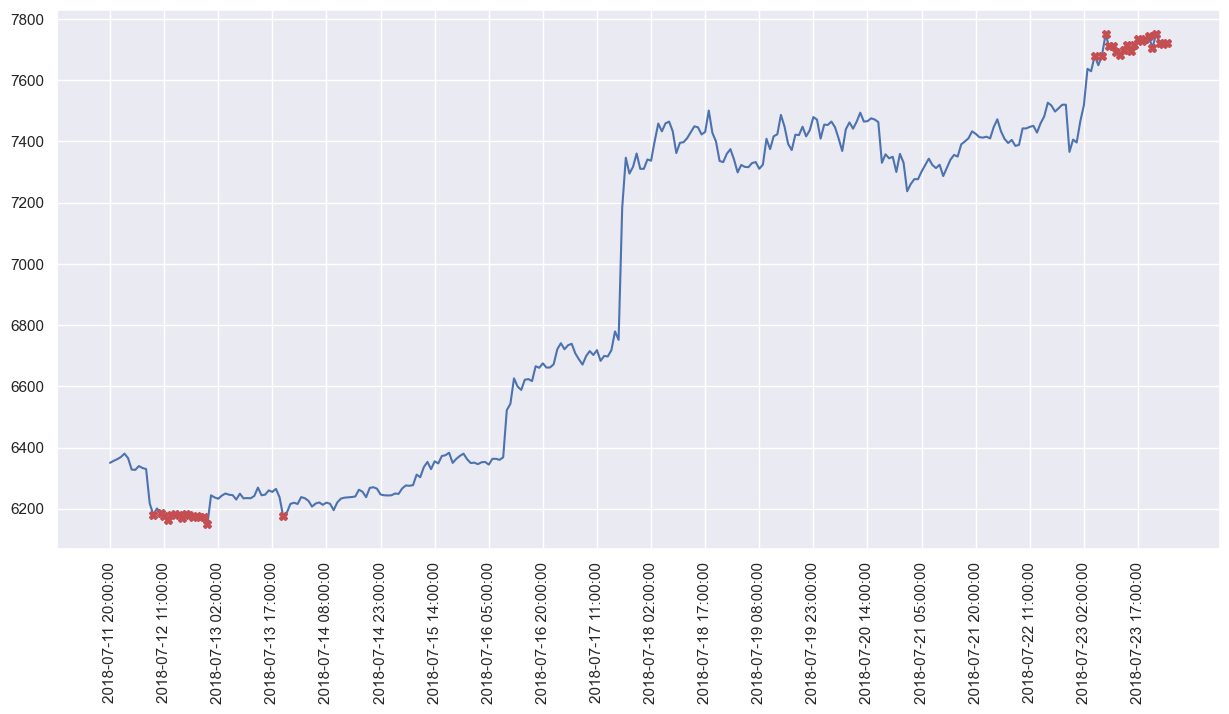

In [129]:
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal)
plt.plot(
    np.arange(len(signal)),
    signal,
    'X',
    label = 'outliers',
    markevery = outliers,
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)
plt.show()

In [130]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler().fit(df[['Polarity', 'Sensitivity', 'Close_Price']])
scaled = minmax.transform(df[['Polarity', 'Sensitivity', 'Close_Price']])

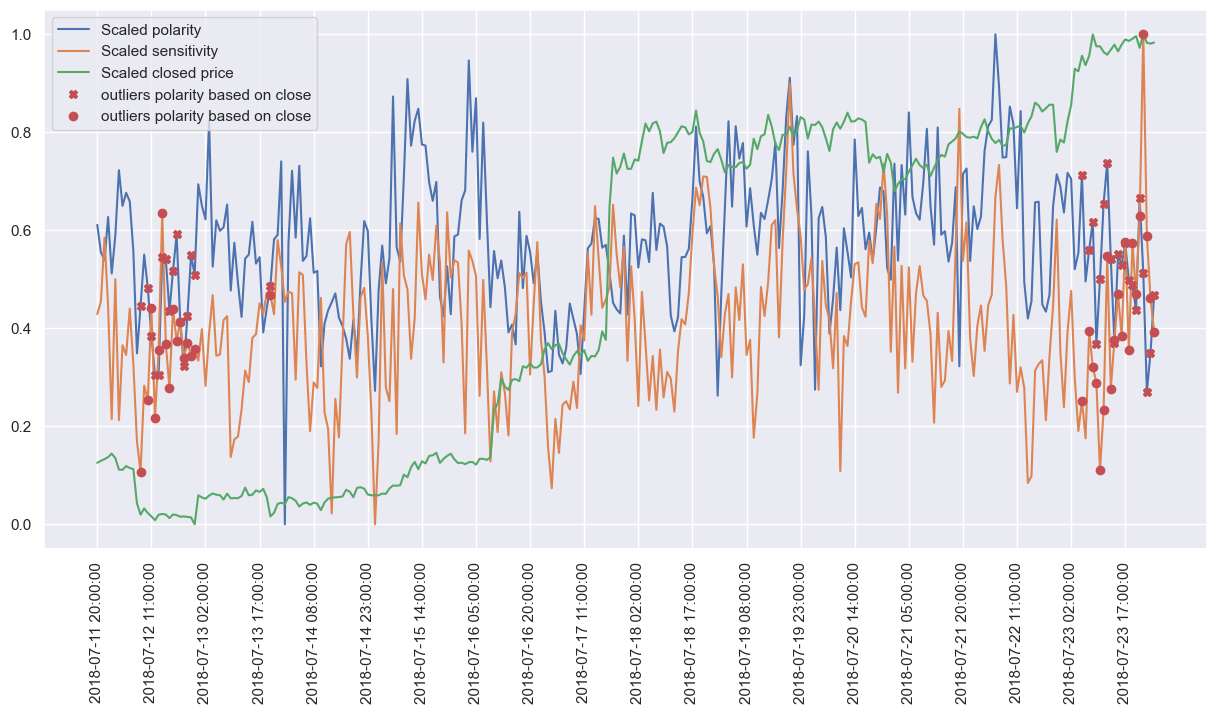

In [131]:
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), scaled[:, 0], label = 'Scaled polarity')
plt.plot(np.arange(len(signal)), scaled[:, 1], label = 'Scaled sensitivity')
plt.plot(np.arange(len(signal)), scaled[:, 2], label = 'Scaled closed price')
plt.plot(
    np.arange(len(signal)),
    scaled[:, 0],
    'X',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)
plt.plot(
    np.arange(len(signal)),
    scaled[:, 1],
    'o',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)
plt.legend()
plt.show()

Doesnt show much from trending, how about covariance correlation?

## Pearson correlation

In [132]:
def df_shift(df, lag=0, start=1, skip=1, rejected_columns=[]):
    df = df.copy()
    if not lag:
        return df
    cols = {}
    for i in range(start, lag + 1, skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k, v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i += 1
        df = pd.concat([df, dfn], axis=1)
    return df


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23296\3480205501.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df.corr())
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23296\3480205501.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(),


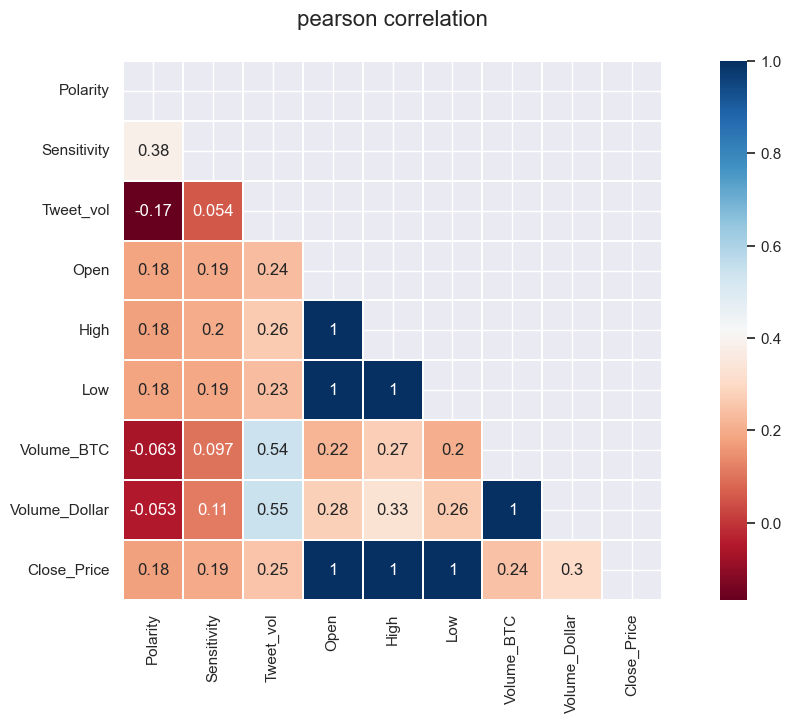

In [133]:
colormap = plt.cm.RdBu
plt.figure(figsize = (15, 7))
plt.title('pearson correlation', y = 1.05, size = 16)

mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df.corr(),
    mask = mask,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

In [134]:
df_new = df_shift(df, lag = 42, start = 7, skip = 7)
df_new.shape

(294, 70)

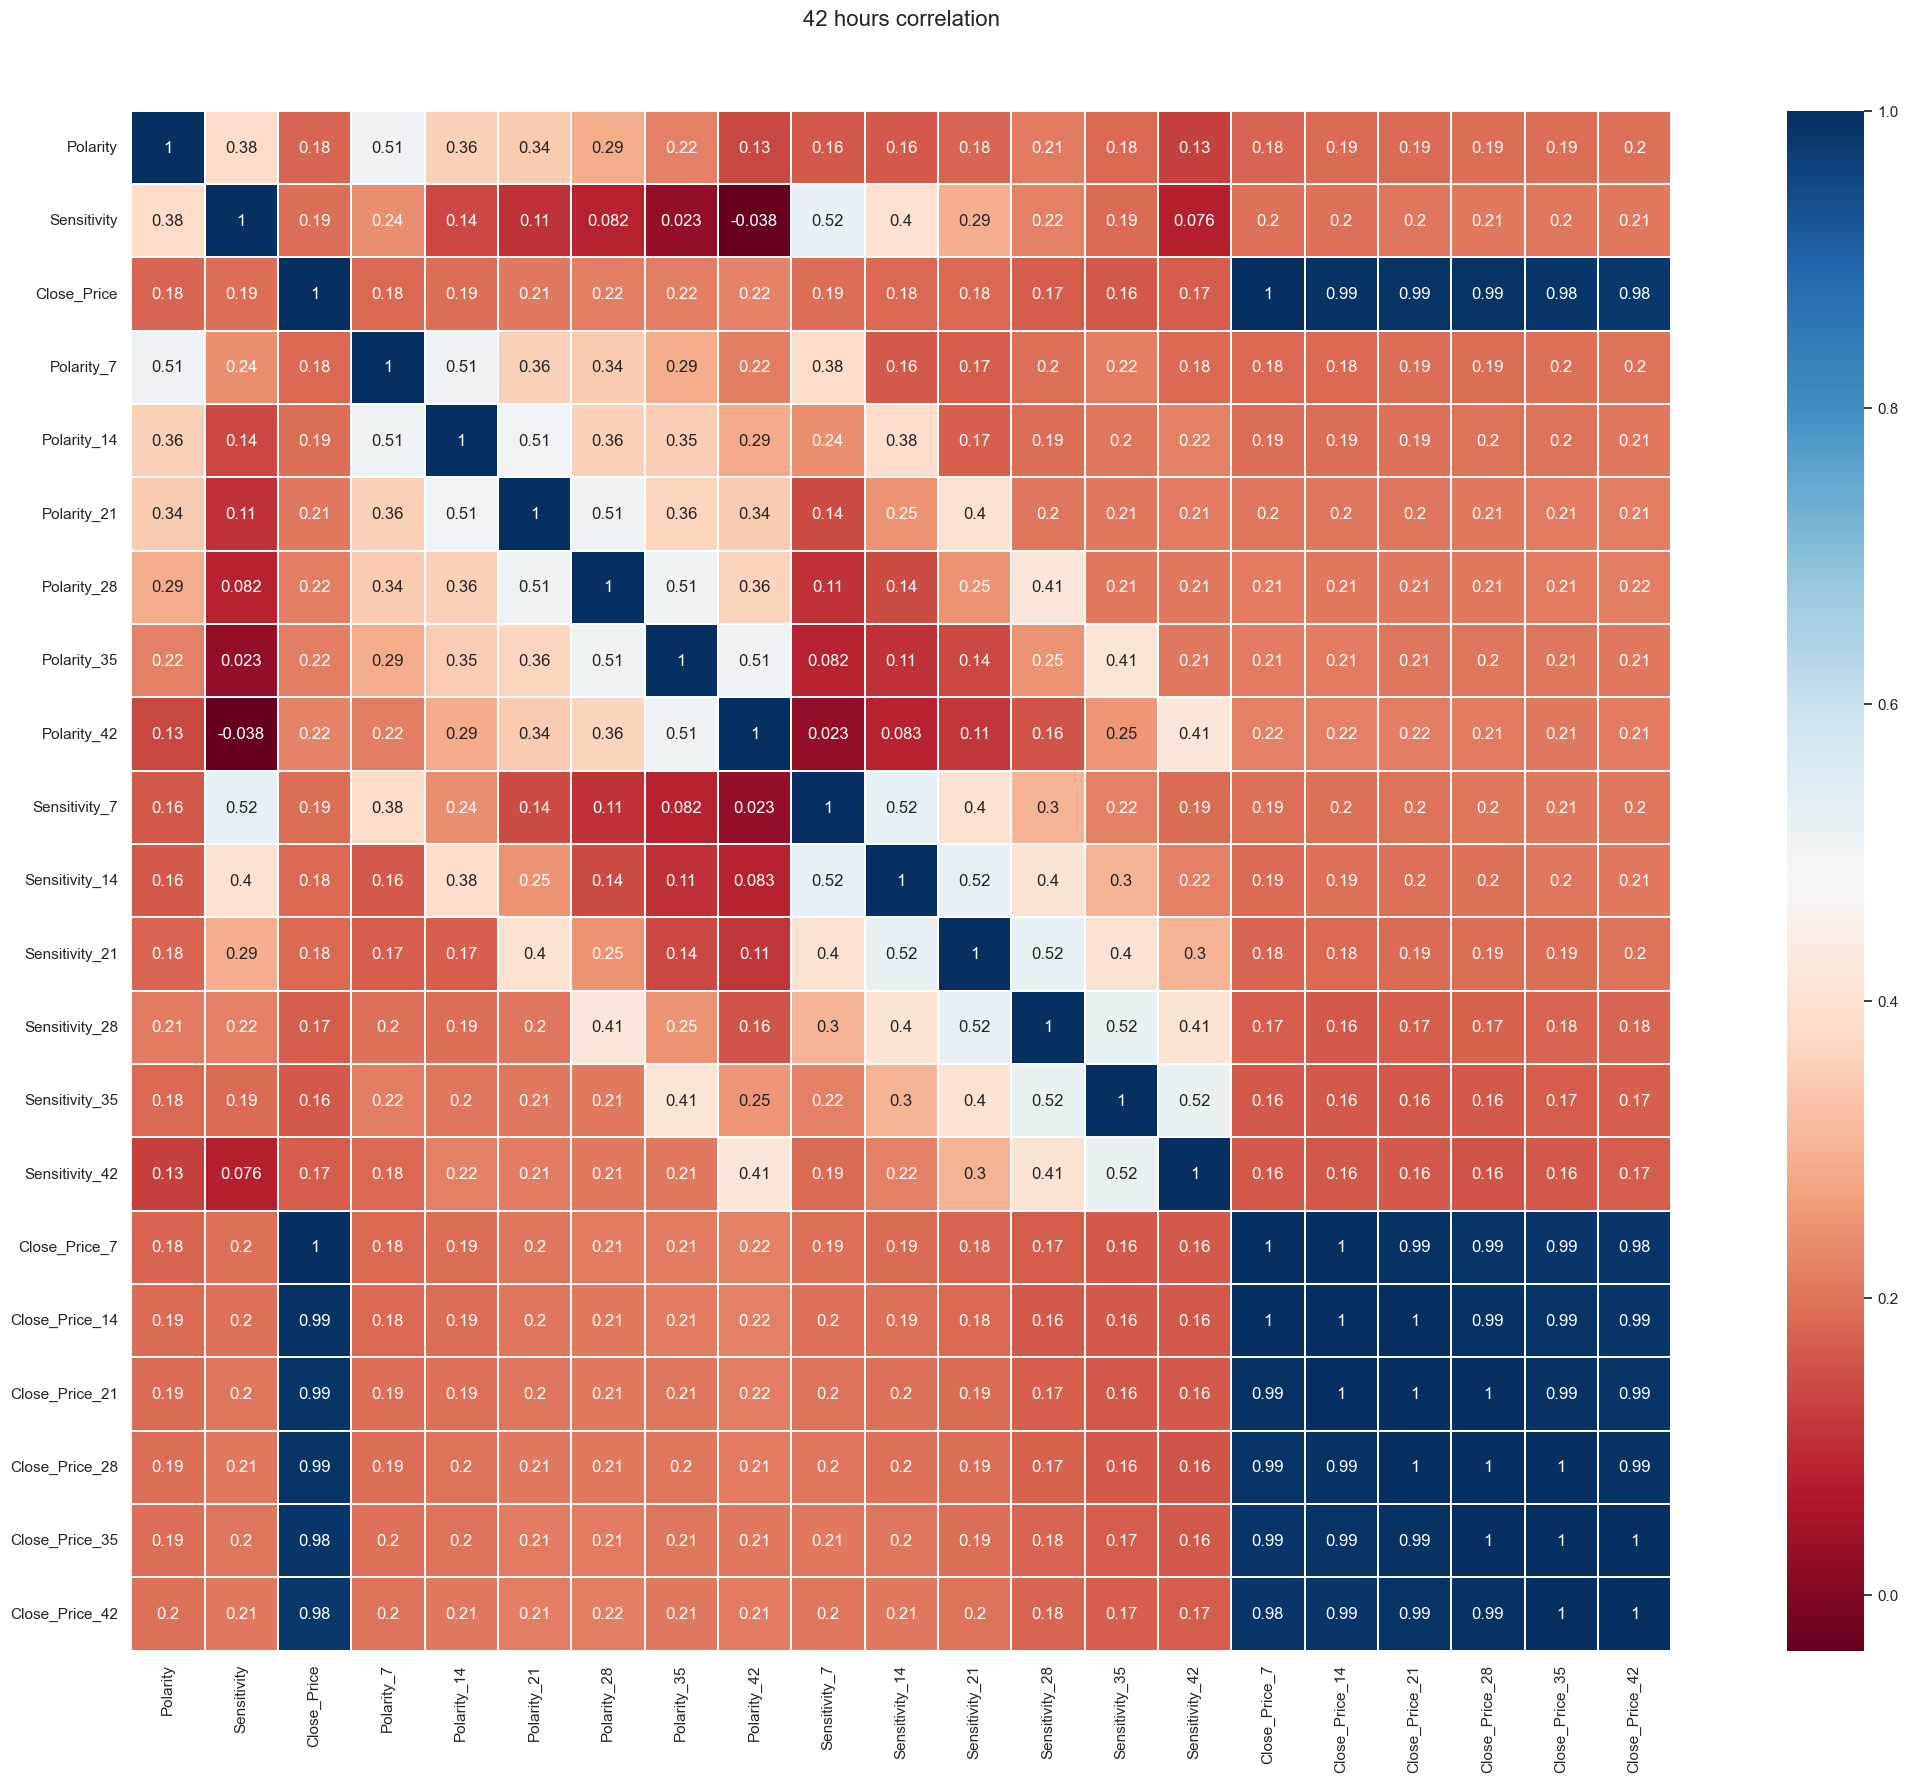

In [135]:
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 20))
ax = plt.subplot(111)
plt.title('42 hours correlation', y = 1.05, size = 16)
selected_column = [
    col
    for col in list(df_new)
    if any([k in col for k in ['Polarity', 'Sensitivity', 'Close']])
]

sns.heatmap(
    df_new[selected_column].corr(),
    ax = ax,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

## How about we check trends from moving average? i chose 7, 14, 30 hours

I think i had too much playing daily trending data

In [136]:
def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period, len(signal)):
        buffer.append(signal[i - period : i].mean())
    return buffer

In [137]:
signal = np.copy(df['Close_Price'].values)
ma_7 = moving_average(signal, 7)
ma_14 = moving_average(signal, 14)
ma_30 = moving_average(signal, 30)

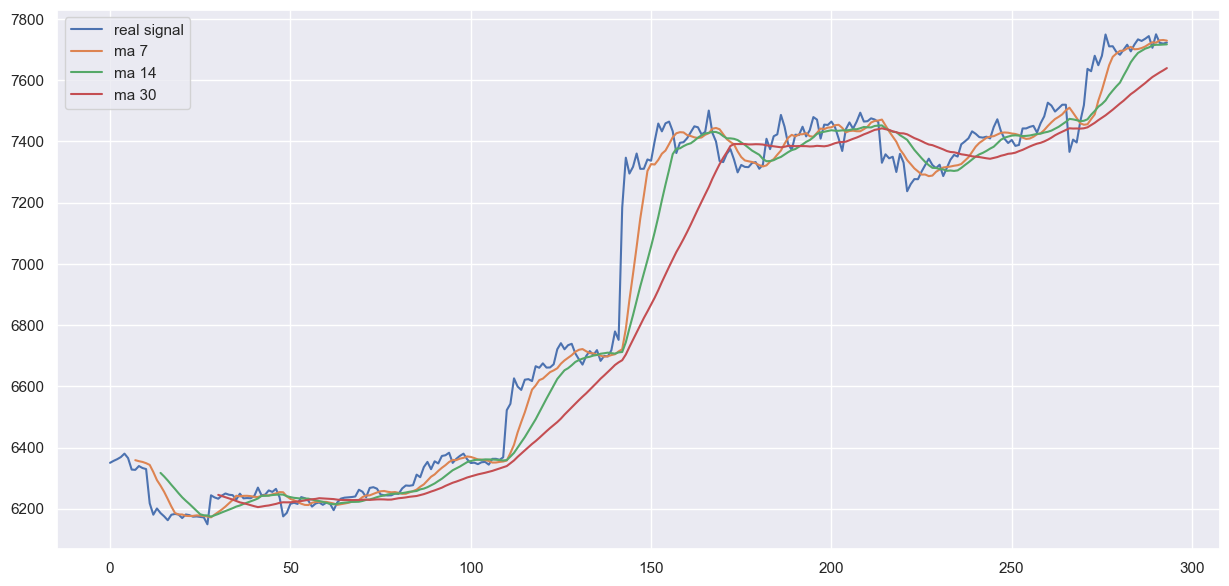

In [138]:
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.plot(np.arange(len(signal)), ma_7, label = 'ma 7')
plt.plot(np.arange(len(signal)), ma_14, label = 'ma 14')
plt.plot(np.arange(len(signal)), ma_30, label = 'ma 30')
plt.legend()
plt.show()

Trends gonna increase anyway!

## 开始深度学习 LSTM

In [139]:
import random

num_layers = 1
learning_rate = 0.005
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.6


In [140]:
dates = pd.to_datetime(df.iloc[:, 0]).tolist()

In [141]:
class Model:
    def __init__(self, learning_rate, num_layers, input_dim, size_layer, dropout_rate=0.6):
        self.model = tf.keras.Sequential()

        for _ in range(num_layers):
            self.model.add(tf.keras.layers.LSTM(size_layer, return_sequences=True if _ < num_layers - 1 else False))
            self.model.add(tf.keras.layers.Dropout(dropout_rate))

        self.model.add(tf.keras.layers.Dense(input_dim))

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate),
            loss='mean_squared_error'
        )

    def train(self, X, Y, epochs, batch_size):
        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, X):
        return self.model.predict(X)

#### 数据预处理

In [142]:
# 正则化数据
minmax = MinMaxScaler().fit(df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype('float32'))
df_scaled = minmax.transform(df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype('float32'))
df_scaled = pd.DataFrame(df_scaled)

df_scaled.head()


,0,1,2,3
0,0.611105,0.429055,0.181916,0.125479
1,0.555312,0.454335,0.192380,0.129527
2,0.539534,0.584943,0.131741,0.132931
3,0.627175,0.445375,0.111618,0.137210
4,0.511893,0.214693,0.134156,0.144218


In [143]:
# 转换数据以适应 LSTM 模型
X_train = []
Y_train = []

for i in range(timestamp, len(df_scaled)):
    X_train.append(df_scaled.iloc[i-timestamp:i].values)
    Y_train.append(df_scaled.iloc[i].values)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

# 创建并训练模型
modelnn = Model(learning_rate, num_layers, df_scaled.shape[1], size_layer, dropout_rate)
modelnn.train(X_train, Y_train, epochs=epoch, batch_size=32)


Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1263  
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0349 
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0262 
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0222 
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0211 
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0235 
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215 
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0220 
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0225 
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 
Epoch 13/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0178 
Epoch 14/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0181 
Epoch 15/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

####  预测数据

我们需要将数据缩放到0到1之间，或者缩放到你想要的范围，但必须确保数据值不小于-1且不大于1。这是因为LSTM使用了tanh函数，如果压缩了较大的数值可能会导致后续出现梯度消失的问题。

In [144]:
# 预测
predictions = modelnn.predict(X_train)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


#### 预测未来的时间序列数据

In [145]:
def predict_future(future_count, df, dates, modelnn, indices={}):
    date_ori = dates[:]
    cp_df = df.copy()
    output_predict = np.zeros((cp_df.shape[0] + future_count, cp_df.shape[1]))
    output_predict[0] = cp_df.iloc[0]
    upper_b = (cp_df.shape[0] // timestamp) * timestamp

    for k in range(0, (df.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = modelnn.predict(np.expand_dims(cp_df.iloc[k : k + timestamp].values, axis=0))
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    out_logits = modelnn.predict(np.expand_dims(cp_df.iloc[upper_b:].values, axis=0))
    output_predict[upper_b + 1 : cp_df.shape[0] + 1] = out_logits

    cp_df.loc[cp_df.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(hours=1))

    if indices:
        for key, item in indices.items():
            cp_df.iloc[-1, key] = item

    for i in range(future_count - 1):
        out_logits = modelnn.predict(np.expand_dims(cp_df.iloc[-timestamp:].values, axis=0))
        output_predict[cp_df.shape[0]] = out_logits[-1]
        cp_df.loc[cp_df.shape[0]] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(hours=1))

        if indices:
            for key, item in indices.items():
                cp_df.iloc[-1, key] = item

    return {'date_ori': date_ori, 'df': cp_df.values}


#### 定义平滑函数

In [146]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer


#### 预测并绘制结果

In [147]:
predict_30 = predict_future(30, df_scaled, dates, modelnn)
predict_30['df'] = minmax.inverse_transform(predict_30['df'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

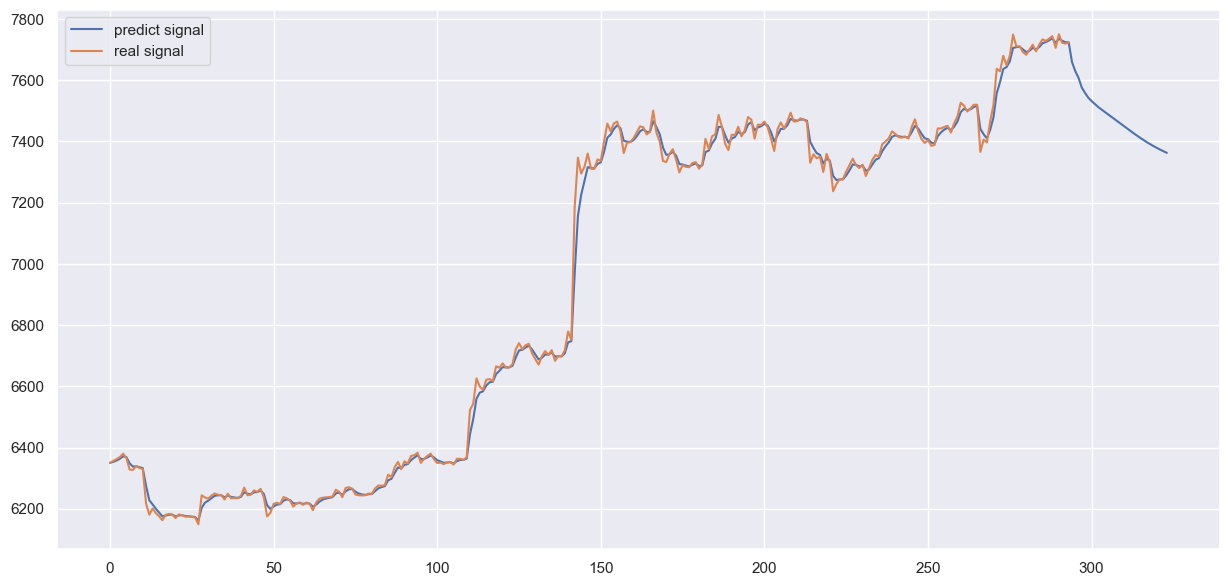

In [148]:
plt.figure(figsize=(15, 7))
plt.plot(
    np.arange(len(predict_30['date_ori'])),
    anchor(predict_30['df'][:, -1], 0.5),
    label='predict signal',
)
# 使用原始的 df 数据框来获取 'Close_Price' 列
plt.plot(np.arange(len(df)), df['Close_Price'], label='real signal')
plt.legend()
plt.show()
# 保存整个模型（包括架构和权重）
# modelnn.model.save('quant_model.h5')


#### 使用抱抱脸数据测试

In [149]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta

# 读取Parquet格式的数据
df_test  = pd.read_parquet('BTC_USDT_ohlcv_data.parquet')

# 显示数据的前几行以确保数据加载正确
print(df_test .head())


             timestamp     open     high      low    close     volume
0  2017-08-17 12:00:00  4261.48  4280.56  4261.48  4261.48   2.189061
1  2017-08-17 12:15:00  4261.48  4270.41  4261.32  4261.45   9.119865
2  2017-08-17 12:30:00  4280.00  4310.07  4267.99  4310.07  21.923552
3  2017-08-17 12:45:00  4310.07  4313.62  4291.37  4308.83  13.948531
4  2017-08-17 13:00:00  4308.83  4328.69  4304.31  4304.31   5.101153


In [150]:
# 将字符串格式的时间戳转换为datetime格式
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

# 设置时间戳为索引
df_test.set_index('timestamp', inplace=True)

# 补充训练时使用的特征
df_test['Polarity'] = 0.0  # 新数据集中可能没有Polarity，所以用0填充
df_test['Sensitivity'] = 0.0  # 用0填充
df_test['Tweet_vol'] = 0.0  # 用0填充

# 根据训练数据中的范围生成随机数
# n = len(df_test)
# df_test['Polarity'] = np.random.uniform(0.05, 0.14, n)
# df_test['Sensitivity'] = np.random.uniform(0.17, 0.27, n)
# df_test['Tweet_vol'] = np.random.uniform(3000, 10500, n)

# 如果Close_Price没有，可以用close代替
df_test['Close_Price'] = df_test['close']  # 使用现有的close列

# 重新排列列顺序以匹配训练时的顺序
df_test = df_test[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']]

# 归一化数据
minmax = MinMaxScaler().fit(df_test.astype('float32'))
df_test_scaled = minmax.transform(df_test.astype('float32'))

df_test_scaled = pd.DataFrame(df_test_scaled, columns=df_test.columns, index=df_test.index)

# 设置时间戳长度，确保与训练时一致
timestamp = 5

# 准备测试数据
X_test = []

for i in range(timestamp, len(df_test_scaled)):
    X_test.append(df_test_scaled.iloc[i-timestamp:i].values)

X_test = np.array(X_test)

# 检查X_test的形状
print("X_test shape:", X_test.shape)


X_test shape: (243276, 5, 4)


7603/7603 ━━━━━━━━━━━━━━━━━━━━ 5s 631us/step


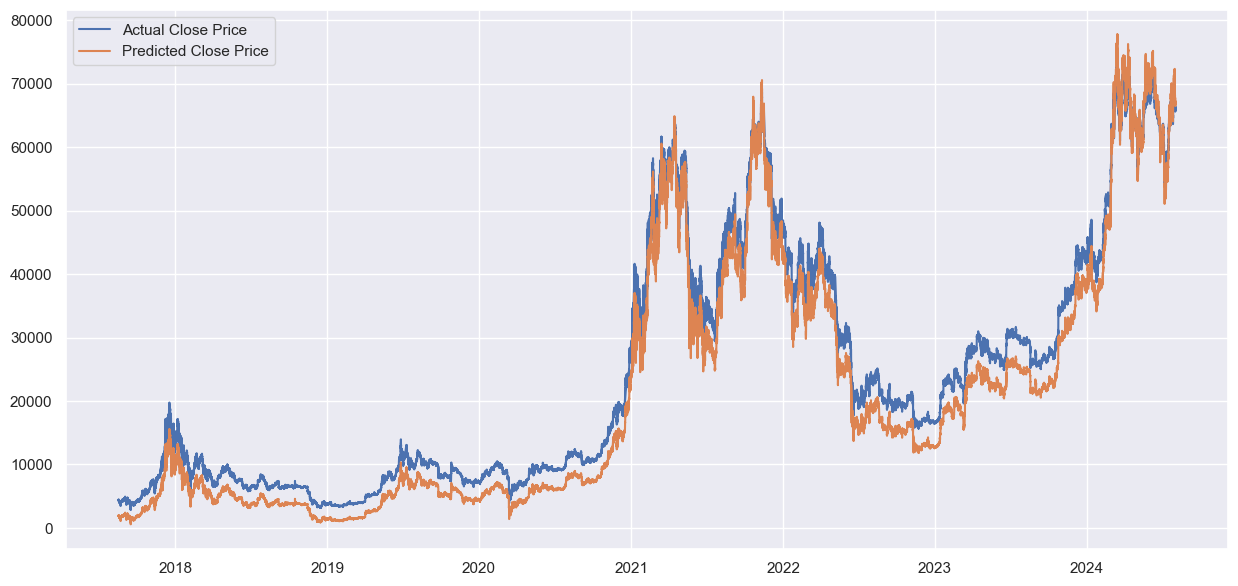

In [151]:
# 使用训练好的模型进行预测
predictions = modelnn.predict(X_test)

# 反归一化预测结果
predictions = minmax.inverse_transform(predictions)

# 提取预测的 Close_Price 值
predicted_close = predictions[:, -1]  # 'Close_Price' 是最后一列

# 可视化结果与实际 close 值进行对比
plt.figure(figsize=(15, 7))
plt.plot(df_test.index[timestamp:], df_test['Close_Price'][timestamp:], label='Actual Close Price')
plt.plot(df_test.index[timestamp:], predicted_close, label='Predicted Close Price')
plt.legend()
plt.show()

#### 预测未来时间序列数据,有点太准了

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━

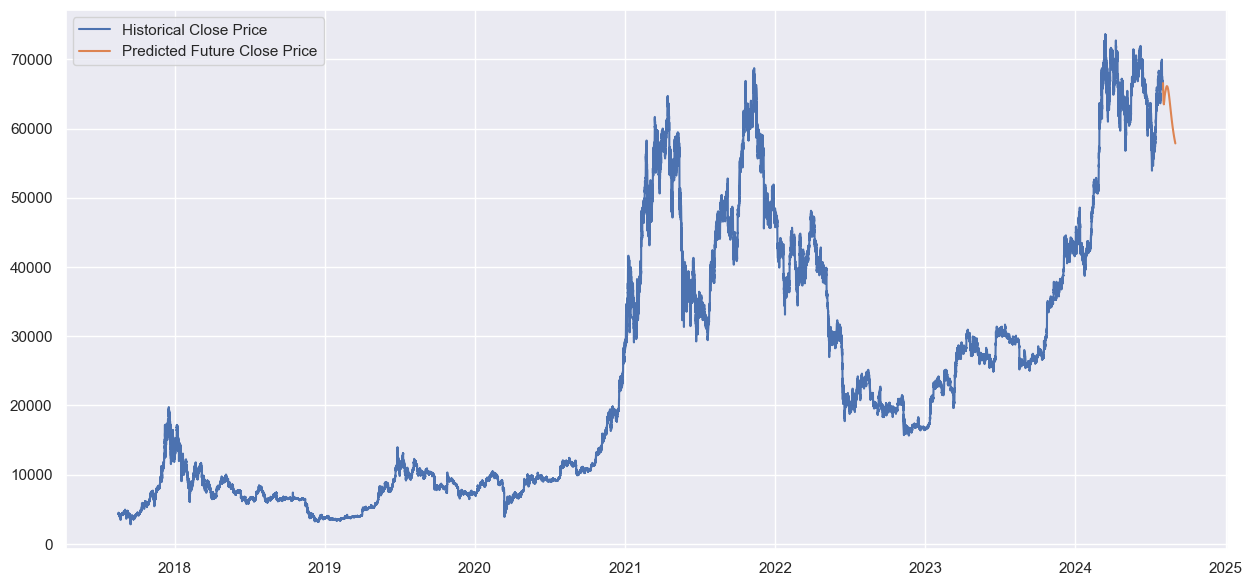

In [152]:
# 设置要预测的未来天数
future_days = 31  # 预测到9月结束（8月的31天）

# 从现有数据中获取最近的timestamp个时间步的数据来初始化预测
last_sequence = df_test_scaled[-timestamp:].values

# 生成未来数据
future_predictions = []

for _ in range(future_days):
    # 进行预测
    prediction = modelnn.predict(last_sequence[np.newaxis, :, :])
      
    # 将预测的结果添加到future_predictions中
    future_predictions.append(prediction[0])
    
    # 更新last_sequence，使其包含新预测的结果
    last_sequence = np.vstack([last_sequence[1:], prediction])

# 反归一化预测结果
future_predictions = np.array(future_predictions)
future_predictions = minmax.inverse_transform(future_predictions)

# 获取未来日期范围
last_date = df_test.index[-1]
future_dates = pd.date_range(last_date + timedelta(days=1), periods=future_days, freq='D')

# 将预测结果与日期结合
future_df = pd.DataFrame(future_predictions, columns=df_test.columns, index=future_dates)

# 可视化未来的预测结果
plt.figure(figsize=(15, 7))
plt.plot(df_test.index, df_test['Close_Price'], label='Historical Close Price')
plt.plot(future_df.index, future_df['Close_Price'], label='Predicted Future Close Price')
plt.legend()
plt.show()

#### 使用binance数据测试

                        open     high      low    close     volume
open_time                                                         
2024-08-01 00:00:00  64601.8  64824.4  64320.0  64626.4  11766.814
2024-08-01 01:00:00  64624.7  64801.9  64083.0  64172.6  13276.961
2024-08-01 02:00:00  64172.7  64236.1  63863.3  64081.0  17296.032
2024-08-01 03:00:00  64081.1  64101.1  63722.0  63912.8  10737.165
2024-08-01 04:00:00  63912.7  64036.4  63600.0  63716.9  11973.073
            open_time  Polarity  Sensitivity  Tweet_vol  Close_Price
0 2024-08-01 00:00:00       0.0          0.0        0.0      64626.4
1 2024-08-01 01:00:00       0.0          0.0        0.0      64172.6
2 2024-08-01 02:00:00       0.0          0.0        0.0      64081.0
3 2024-08-01 03:00:00       0.0          0.0        0.0      63912.8
4 2024-08-01 04:00:00       0.0          0.0        0.0      63716.9
X_test shape: (331, 5, 4)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


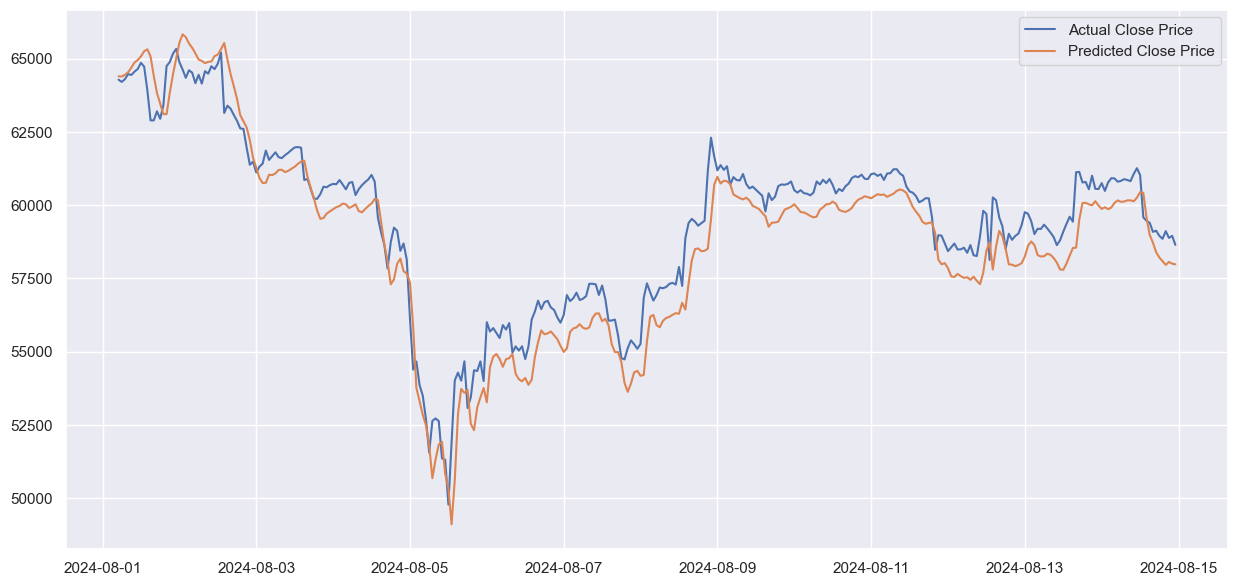

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━

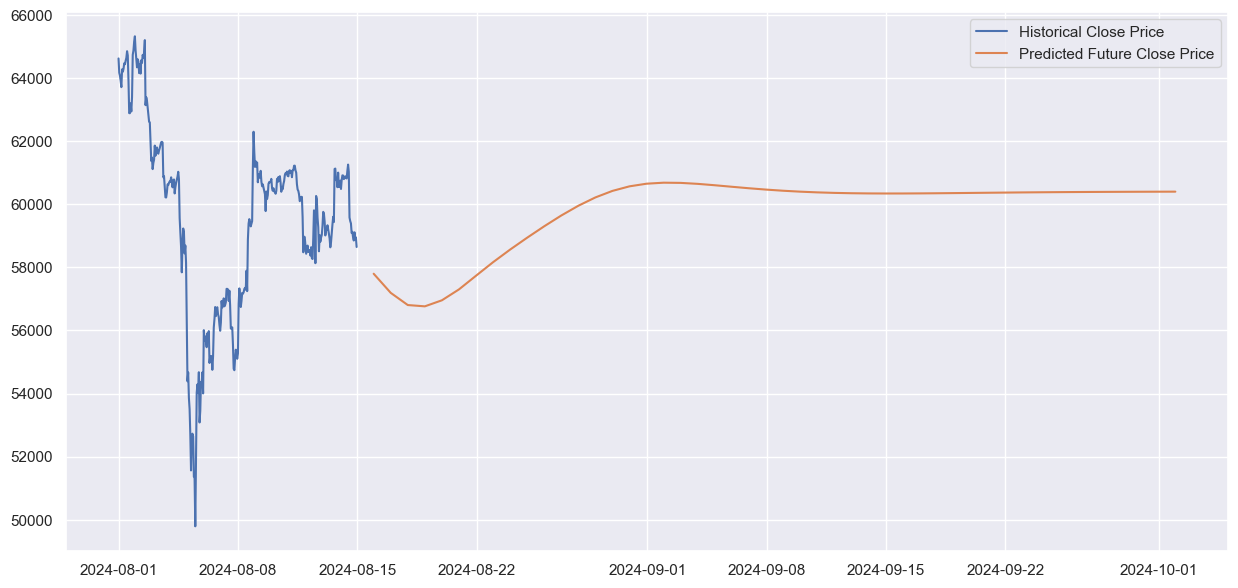

In [153]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta

# 定义文件夹路径
folder_path = 'D:\crypto-doge\BTCUSDT-1h-2024-08-01-12'  
# folder_path = 'D:\crypto-doge\BTCUSDT-1h'  


# 初始化一个空的DataFrame用于存储所有文件的数据
df_list = []

# 遍历文件夹中的所有CSV文件
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # 加载CSV文件，确保第一行作为标题行
        df = pd.read_csv(os.path.join(folder_path, filename), header=0)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 
                      'close_time', 'quote_volume', 'count', 'taker_buy_volume', 
                      'taker_buy_quote_volume', 'ignore']
        
        # 将时间戳转换为datetime格式
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        
        # 设置时间戳为索引
        df.set_index('open_time', inplace=True)
        
        # 只保留模型所需的列
        df = df[['open', 'high', 'low', 'close', 'volume']]
        
        # 将数据添加到列表中
        df_list.append(df)

# 将所有DataFrame合并为一个
df_resampled = pd.concat(df_list)

# 显示数据的前几行以确保数据加载正确
print(df_resampled.head())

# # 补充训练时使用的特征
# n = len(df_all)
# df_all['Polarity'] = np.random.uniform(0.05, 0.14, n)
# df_all['Sensitivity'] = np.random.uniform(0.17, 0.27, n)
# df_all['Tweet_vol'] = np.random.uniform(3000, 10500, n)
# 补充训练时使用的特征
df_resampled['Polarity'] = 0.0  # 新数据集中可能没有Polarity，所以用0填充
df_resampled['Sensitivity'] = 0.0  # 用0填充
df_resampled['Tweet_vol'] = 0.0  # 用0填充

# 如果Close_Price没有，可以用close代替
df_resampled['Close_Price'] = df_resampled['close']  # 使用现有的close列

# 重新排列列顺序以匹配训练时的顺序
df_resampled = df_resampled[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']]
# 
# # 重新采样为1小时数据
# df_resampled = df_all.resample('1H').agg({
#     'Polarity': 'mean',        # 取每小时情感倾向的平均值
#     'Sensitivity': 'mean',     # 取每小时情感敏感度的平均值
#     'Tweet_vol': 'mean',       # 取每小时推文量的平均值
#     'Close_Price': 'last'      # 取每小时最后一个数据作为收盘价
# }).fillna(0)# 对缺失值进行填充，防止NaN影响后续操作



# 重置索引，使 timestamp 列恢复为普通列
df_resampled.reset_index(inplace=True)

# 查看重新采样后的数据
print(df_resampled.head())

# 直接下载了1小时数据，上文df_all替换为df_resampled变量使用

# 去除时间列，仅保留数值数据用于归一化
data_to_scale = df_resampled.drop(columns=['open_time'])

# 归一化数据
minmax = MinMaxScaler().fit(data_to_scale.astype('float32'))
data_scaled = minmax.transform(data_to_scale.astype('float32'))

df_all_scaled = pd.DataFrame(data_scaled, columns=data_to_scale.columns, index=df_resampled['open_time'])

# 设置时间戳长度，确保与训练时一致
timestamp = 5

# 准备测试数据
X_test = []

for i in range(timestamp, len(df_all_scaled)):
    X_test.append(df_all_scaled.iloc[i-timestamp:i].values)

X_test = np.array(X_test)

# 检查X_test的形状
print("X_test shape:", X_test.shape)

# 使用训练好的模型进行预测
predictions = modelnn.predict(X_test)

# 反归一化预测结果
predictions = minmax.inverse_transform(predictions)

# 提取预测的 Close_Price 值
predicted_close = predictions[:, -1]  # 'Close_Price' 是最后一列

# 可视化结果与实际 close 值进行对比
plt.figure(figsize=(15, 7))
plt.plot(df_resampled['open_time'][timestamp:], df_resampled['Close_Price'][timestamp:], label='Actual Close Price')
plt.plot(df_resampled['open_time'][timestamp:], predicted_close, label='Predicted Close Price')
plt.legend()
plt.show()

# 设置要预测的未来天数
future_days = 48  # 预测未来31天

# 从现有数据中获取最近的timestamp个时间步的数据来初始化预测
last_sequence = df_all_scaled[-timestamp:].values

# 生成未来数据
future_predictions = []

for _ in range(future_days):
    # 进行预测
    prediction = modelnn.predict(last_sequence[np.newaxis, :, :])
    
    # 将预测的结果添加到future_predictions中
    future_predictions.append(prediction[0])
    
    # 更新last_sequence，使其包含新预测的结果
    last_sequence = np.vstack([last_sequence[1:], prediction])

# 反归一化预测结果
future_predictions = np.array(future_predictions)
future_predictions = minmax.inverse_transform(future_predictions)

# 获取未来日期范围
last_date = df_resampled['open_time'].iloc[-1]
future_dates = pd.date_range(last_date + timedelta(days=1), periods=future_days, freq='D')

# 将预测结果与日期结合
future_df = pd.DataFrame(future_predictions, columns=data_to_scale.columns, index=future_dates)

# 可视化未来的预测结果
plt.figure(figsize=(15, 7))
plt.plot(df_resampled['open_time'], df_resampled['Close_Price'], label='Historical Close Price')
plt.plot(future_df.index, future_df['Close_Price'], label='Predicted Future Close Price')
plt.legend()
plt.show()

#### 回测

LSTM 预测趋势 vs 实际趋势 (前 10 个值)：
   predicted_trend  actual_trend
0     64394.562500       64626.4
1     64387.300781       64172.6
2     64448.667969       64081.0
3     64534.253906       63912.8
4     64692.093750       63716.9
5     64866.933594       64279.5
6     64951.921875       64204.5
7     65075.187500       64297.4
8     65247.859375       64472.2
9     65315.757812       64441.9
生成的交易信号 (前 10 个值)：
   signal
0    -1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
最终交易信号分布：
-1.0    273
 1.0     58
Name: signal, dtype: int64
日期 2024-08-01 01:00:00: 买入 0.007791 单位，价格为 64172.6, 总余额 9500.00, 持仓 0.007791
日期 2024-08-01 02:00:00: 买入 0.007803 单位，价格为 64081.0, 总余额 9000.00, 持仓 0.015594
日期 2024-08-01 03:00:00: 买入 0.007823 单位，价格为 63912.8, 总余额 8500.00, 持仓 0.023417
日期 2024-08-01 04:00:00: 买入 0.007847 单位，价格为 63716.9, 总余额 8000.00, 持仓 0.031264
日期 2024-08-01 05:00:00: 买入 0.007779 单位，价格为 64279.5, 总余额 7500.00, 持仓 0.039043
日期 2024-08-01 06:00:00: 买入 0.0077

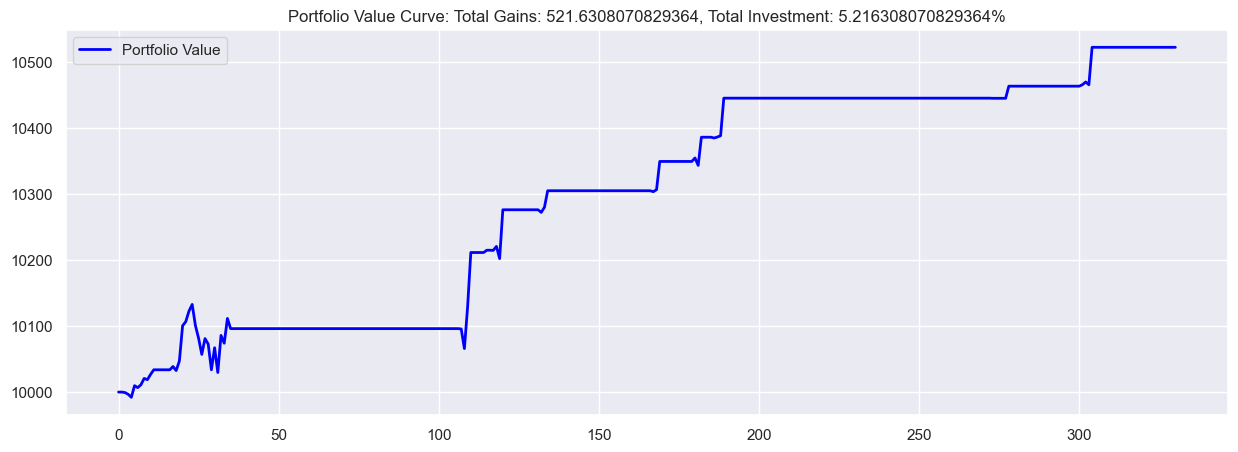

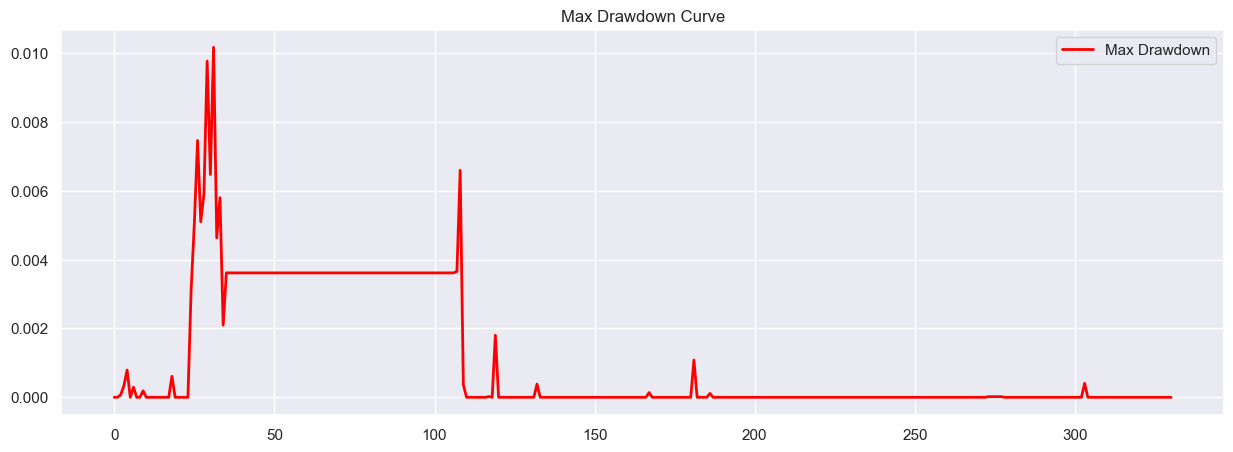

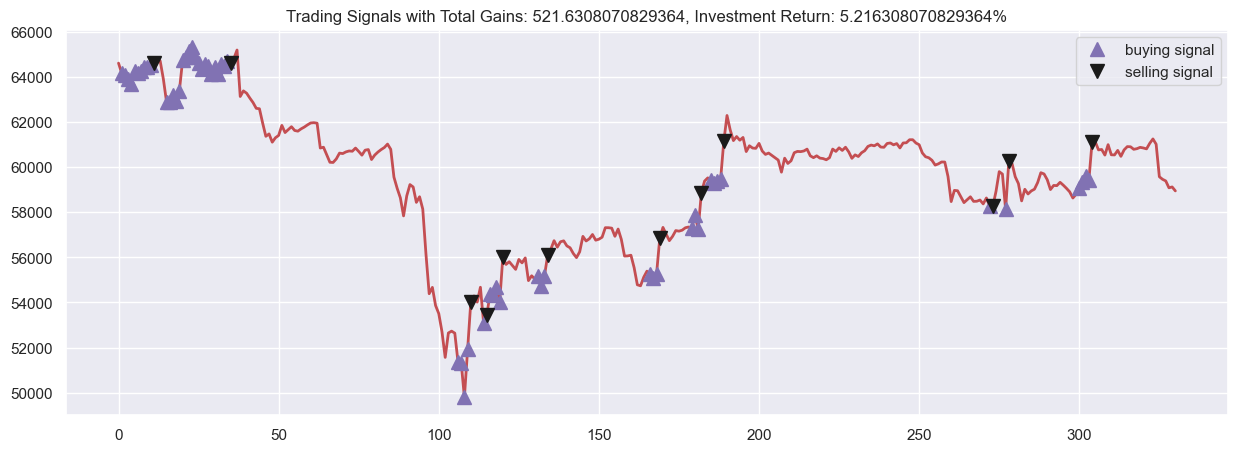

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 假设 df_resampled 和 predictions 已经存在
min_length = min(len(predictions), len(df_resampled))

# 裁剪 predictions 和 df_resampled 使其长度匹配
predictions = predictions[:min_length]
df_resampled = df_resampled.iloc[:min_length]

# 创建 signals DataFrame
signals = pd.DataFrame(index=df_resampled.index)
signals['signal'] = 0.0
signals['predicted_trend'] = predictions[:, -1]  # 假设模型预测的最后一列是预测的Close价格
signals['actual_trend'] = df_resampled['Close_Price'].values

# 调整 predicted_trend 使其与实际价格趋势在同一量级
scaler_predicted = MinMaxScaler()
predicted_trend_scaled = scaler_predicted.fit_transform(predictions[:, -1].reshape(-1, 1))
signals['predicted_trend'] = scaler_predicted.inverse_transform(predicted_trend_scaled)

# 打印 LSTM 预测的趋势与实际趋势的前几个值
print("LSTM 预测趋势 vs 实际趋势 (前 10 个值)：")
print(signals[['predicted_trend', 'actual_trend']].head(10))

# 基于预测趋势生成交易信号
signals['signal'] = np.where(signals['predicted_trend'] > signals['actual_trend'], 1.0, -1.0)

# 打印信号生成的前几个值
print("生成的交易信号 (前 10 个值)：")
print(signals[['signal']].head(10))

# 打印最终交易信号分布
print("最终交易信号分布：")
print(signals['signal'].value_counts())

# 定义基于LSTM预测的改进交易策略并计算最大回撤
def lstm_based_strategy(real_movement, signal, dates, initial_money=10000, buy_amount=500, max_sell=10, stop_loss=0.03, take_profit=0.07):
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0
    portfolio_value = []

    for i in range(len(signal)):
        current_date = dates[i]  # 获取当前日期
        if signal[i] == 1:  # 买入信号
            # 如果当前余额足够购买 buy_amount 的比特币
            if initial_money >= buy_amount:
                buy_units = buy_amount / real_movement[i]  # 计算以 buy_amount 的资金可以买入多少单位的比特币
                initial_money -= buy_amount
                current_inventory += buy_units
                states_buy.append(i)
                print(f'日期 {current_date}: 买入 {buy_units:.6f} 单位，价格为 {real_movement[i]}, 总余额 {initial_money:.2f}, 持仓 {current_inventory:.6f}')
            else:
                print(f'日期 {current_date}: 余额不足，无法在价格 {real_movement[i]} 买入 {buy_amount} USDT 的比特币')

        elif signal[i] == -1 and current_inventory > 0:  # 卖出信号
            sell_units = min(current_inventory, max_sell)
            initial_money += sell_units * real_movement[i]
            current_inventory -= sell_units
            states_sell.append(i)
            print(f'日期 {current_date}: 卖出 {sell_units:.6f} 单位，价格为 {real_movement[i]}, 总余额 {initial_money:.2f}, 持仓 {current_inventory:.6f}')

            # 止盈止损逻辑
            if (real_movement[i] >= real_movement[states_buy[-1]] * (1 + take_profit)) or \
               (real_movement[i] <= real_movement[states_buy[-1]] * (1 - stop_loss)):
                initial_money += current_inventory * real_movement[i]
                print(f'日期 {current_date}: 达到止损/止盈，全部卖出，价格为 {real_movement[i]}, 总余额 {initial_money:.2f}')
                current_inventory = 0

        # 每日更新投资组合的总价值
        portfolio_value.append(initial_money + current_inventory * real_movement[i])

    # 计算最大回撤
    portfolio_value = np.array(portfolio_value)
    running_max = np.maximum.accumulate(portfolio_value)
    drawdown = (running_max - portfolio_value) / running_max
    max_drawdown = np.max(drawdown)

    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money

    print(f"最大回撤: {max_drawdown * 100:.2f}%")
    return states_buy, states_sell, total_gains, invest, portfolio_value, drawdown

# 确保 'timestamp' 列为日期时间格式
df_resampled['open_time'] = pd.to_datetime(df_resampled['open_time'])

# 提取日期列用于策略函数
dates = df_resampled['open_time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# 执行基于LSTM预测的策略
states_buy, states_sell, total_gains, invest, portfolio_value, drawdown = lstm_based_strategy(
    df_resampled['Close_Price'].values, signals['signal'].values, dates)

# 绘制资金曲线
plt.figure(figsize=(15, 5))
plt.plot(portfolio_value, color='blue', lw=2, label='Portfolio Value')
plt.title(f'Portfolio Value Curve: Total Gains: {total_gains}, Total Investment: {invest}%')
plt.legend()
plt.show()

# 绘制最大回撤曲线
plt.figure(figsize=(15, 5))
plt.plot(drawdown, color='red', lw=2, label='Max Drawdown')
plt.title('Max Drawdown Curve') 
plt.legend()
plt.show()

# 绘制买入卖出信号
plt.figure(figsize=(15, 5))
plt.plot(df_resampled['Close_Price'], color='r', lw=2.)
plt.plot(df_resampled['Close_Price'], '^', markersize=10, color='m', label='buying signal', markevery=states_buy)
plt.plot(df_resampled['Close_Price'], 'v', markersize=10, color='k', label='selling signal', markevery=states_sell)
plt.title(f'Trading Signals with Total Gains: {total_gains}, Investment Return: {invest}%')
plt.legend()
plt.show()


#### 保存模型

In [155]:
import os
import datetime
import tensorflow as tf

# 训练模型并保存
def save_model_with_metadata(model, model_dir='saved_models', evaluation_metrics=None):
    # 创建保存目录（如果不存在）
    os.makedirs(model_dir, exist_ok=True)

    # 获取当前日期和时间
    now = datetime.datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M%S")

    # 生成模型名称，包含日期、时间和评估结果
    model_name = f"lstm_model_{timestamp}"

    # 如果有评估指标，添加到模型名称
    if evaluation_metrics:
        eval_str = "_".join([f"{key}-{value:.4f}" for key, value in evaluation_metrics.items()])
        model_name += f"_{eval_str}"

    # 保存模型路径
    model_save_path = os.path.join(model_dir, model_name + '.keras')

    # 保存整个模型，包括结构、权重和优化器状态
    model.save(model_save_path)

    print(f"模型已保存到: {model_save_path}")
    return model_save_path

# 假设你已经训练了 modelnn
evaluation_metrics = {
    "loss": modelnn.model.evaluate(X_train, Y_train, verbose=0)  # 这里假设你使用训练集评估模型
}

# 保存模型
model_save_path = save_model_with_metadata(modelnn.model, evaluation_metrics=evaluation_metrics)


模型已保存到: saved_models\lstm_model_20240816_155430_loss-0.0078.keras



###  测试不同的极端情况

In [156]:
scaled_polarity = (minmax.data_max_[0] * 2 - minmax.data_min_[0]) / (
    minmax.data_max_[0] - minmax.data_min_[0]
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23296\2914101830.py:1: RuntimeWarning: invalid value encountered in scalar divide
  scaled_polarity = (minmax.data_max_[0] * 2 - minmax.data_min_[0]) / (


In [157]:
for retry in range(3):
    plt.figure(figsize=(15, 7))
    predict_30 = predict_future(30, df_scaled, dates, modelnn, indices={0: scaled_polarity})
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label='predict signal',
    )
    plt.plot(np.arange(len(df_scaled)), df['Close_Price'], label='real signal')
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━

KeyError: -1

<Figure size 1500x700 with 0 Axes>

我重试了3次，只是为了研究我们的模型是否合适，如果每次重试都有很大的趋势变化，那么我们需要重新训练
这个实验的目的是测试模型在极端情况下的表现。具体来说，我们将 Polarity（情感极性）值增加到其最大值的四倍，然后观察模型的预测结果。
结果解读: 如果 Polarity 值增加到四倍导致预测信号显著下降或波动，这可能表明情感极性对比特币价格的影响在模型中被放大了。模型可以从这些极端情况中学习，帮助更好地理解市场情绪与价格之间的关系。

#### 如果极性是从最大值的四倍开始的，会发生什么？这里提到的极性是指第一个索引。

In [ ]:
# 将Polarity值增加到最大值的四倍
scaled_polarity = (minmax.data_max_[0] * 4 - minmax.data_min_[0]) / (
    minmax.data_max_[0] - minmax.data_min_[0]
)

In [ ]:
plt.figure(figsize=(15, 7))

# 进行三次预测以检查模型的稳定性
for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    predict_30 = predict_future(
        30, df_scaled, dates, modelnn, indices={0: scaled_polarity}
    )
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    
    # 绘制预测信号
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label='predict signal',
    )
    
    # 绘制真实的Close Price信号
    plt.plot(np.arange(len(df)), df['Close_Price'], label='real signal')
    plt.legend()

plt.show()

#### 如果极性是从最小值的四倍开始的，会发生什么？

In [ ]:
# 将Polarity值缩小到最小值的四倍
scaled_polarity = (minmax.data_min_[0] / 4 - minmax.data_min_[0]) / (
    minmax.data_max_[0] - minmax.data_min_[0]
)

In [ ]:
# 创建一个绘图区域
plt.figure(figsize=(15, 7))

# 进行三次预测以检查模型的稳定性
for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    
    # 生成未来30小时的预测
    predict_30 = predict_future(
        30, df_scaled, dates, modelnn, indices={0: scaled_polarity}
    )
    
    # 反归一化预测结果
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    
    # 绘制预测信号
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label='predict signal',
    )
    
    # 绘制真实的Close Price信号
    plt.plot(np.arange(len(df)), df['Close_Price'], label='real signal')
    plt.legend()

# 显示绘图
plt.show()

第二张图出现了偏斜，但我们得到了两个显示正趋势的图表。

正如你所看到的，模型学习到了极性与模型之间的负相关性。如果极性增加，趋势就会下降，反之亦然。

#### 如果情感量（Tweet Volume）是最大值的两倍，会发生什么？情感量是第三个索引。

In [ ]:
# 将Tweet Volume增加到最大值的两倍
scaled_volume = (minmax.data_max_[2] * 2 - minmax.data_min_[2]) / (
    minmax.data_max_[2] - minmax.data_min_[2]
)


In [ ]:
# 创建一个绘图区域
plt.figure(figsize=(15, 7))

# 进行三次预测以检查模型的稳定性
for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    
    # 生成未来30小时的预测
    predict_30 = predict_future(
        30, df_scaled, dates, modelnn, indices={2: scaled_volume}
    )
    
    # 反归一化预测结果
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    
    # 绘制预测信号
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label='predict signal',
    )
    
    # 绘制真实的Close Price信号
    plt.plot(np.arange(len(df)), df['Close_Price'], label='real signal')
    plt.legend()

# 显示绘图
plt.show()

#### 如果情感量（Tweet Volume）是最小值的一半，会发生什么？情感量是第三个索引。

In [ ]:
# 将Tweet Volume缩小到最小值的一半
scaled_volume = (minmax.data_min_[2] / 2 - minmax.data_min_[2]) / (
    minmax.data_max_[2] - minmax.data_min_[2]
)


In [ ]:
# 创建一个绘图区域
plt.figure(figsize=(15, 7))

# 进行三次预测以检查模型的稳定性
for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    
    # 生成未来30小时的预测
    predict_30 = predict_future(
        30, df_scaled, dates, modelnn, indices={2: scaled_volume}
    )
    
    # 反归一化预测结果
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    
    # 绘制预测信号
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label='predict signal',
    )
    
    # 绘制真实的Close Price信号
    plt.plot(np.arange(len(df)), df['Close_Price'], label='real signal')
    plt.legend()

# 显示绘图
plt.show()

正如你所看到的，情感量对模型的学习影响不大。